In [19]:
## Importing libraries
import pandas as pd
import numpy as np
import cv2
import os
import glob
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import Sequential, models
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import save_model, load_model

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import seaborn as sns

from trulens.nn.models import get_model_wrapper
from trulens.nn.attribution import InputAttribution
from trulens.nn.attribution import IntegratedGradients
from trulens.nn.models import get_model_wrapper
from trulens.visualizations import MaskVisualizer

import PIL

In [2]:
path = "./Face Mask Dataset/"
dataset = {
    "image_path": [],
    "mask_status": [],
    "where": []
}

for where in os.listdir(path):
    for status in os.listdir(path+"/"+where):
        for image in glob.glob(path+where+"/"+status+"/"+"*.png"):
            dataset["image_path"].append(image)
            dataset["mask_status"].append(status)
            dataset["where"].append(where)
            
dataset = pd.DataFrame(dataset)
dataset.head()

,image_path,mask_status,where
0,./Face Mask Dataset/Test/WithoutMask/2734.png,WithoutMask,Test
1,./Face Mask Dataset/Test/WithoutMask/4345.png,WithoutMask,Test
2,./Face Mask Dataset/Test/WithoutMask/4423.png,WithoutMask,Test
3,./Face Mask Dataset/Test/WithoutMask/2052.png,WithoutMask,Test
4,./Face Mask Dataset/Test/WithoutMask/3364.png,WithoutMask,Test


                                          image_path  mask_status  where
992   ./Face Mask Dataset/Train/WithoutMask/3975.png  WithoutMask  Train
993    ./Face Mask Dataset/Train/WithoutMask/348.png  WithoutMask  Train
994   ./Face Mask Dataset/Train/WithoutMask/1804.png  WithoutMask  Train
995   ./Face Mask Dataset/Train/WithoutMask/4968.png  WithoutMask  Train
996   ./Face Mask Dataset/Train/WithoutMask/1810.png  WithoutMask  Train
997   ./Face Mask Dataset/Train/WithoutMask/3961.png  WithoutMask  Train
998   ./Face Mask Dataset/Train/WithoutMask/1186.png  WithoutMask  Train
999    ./Face Mask Dataset/Train/WithoutMask/412.png  WithoutMask  Train
1000  ./Face Mask Dataset/Train/WithoutMask/3949.png  WithoutMask  Train
1001  ./Face Mask Dataset/Train/WithoutMask/3791.png  WithoutMask  Train

 After Shuffling 

                                             image_path  mask_status  where
7817         ./Face Mask Dataset/Train/WithMask/672.png     WithMask  Train
5335     ./Face Mask Data

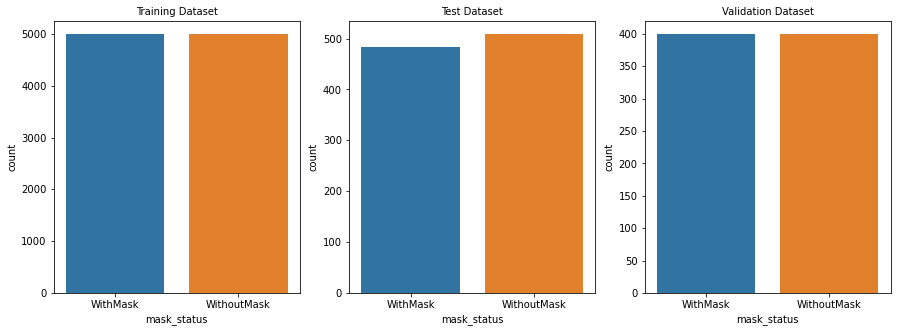

In [4]:
## Splitting train test and Validation Dataset
train_df = dataset[dataset["where"] == "Train"]
test_df = dataset[dataset["where"] == "Test"]
valid_df = dataset[dataset["where"] == "Validation"]

print(train_df.head(10))

## Shuffling the dataset 
train_df = train_df.sample(frac = 1)
test_df = test_df.sample(frac = 1)
valid_df = valid_df.sample(frac = 1)

print("\n After Shuffling \n")
print(train_df.head(10))

plt.figure(figsize = (15, 5))
plt.subplot(1, 3, 1)
sns.countplot(x = train_df["mask_status"])
plt.title("Training Dataset", size = 10)

plt.subplot(1, 3, 2)
sns.countplot(x = test_df["mask_status"])
plt.title("Test Dataset", size = 10)

plt.subplot(1, 3, 3)
sns.countplot(x = valid_df["mask_status"])
plt.title("Validation Dataset", size = 10)

plt.show()

In [5]:
train_df = train_df.reset_index().drop("index", axis = 1)
train_df.head()

,image_path,mask_status,where
0,./Face Mask Dataset/Train/WithMask/672.png,WithMask,Train
1,./Face Mask Dataset/Train/WithoutMask/5173.png,WithoutMask,Train
2,./Face Mask Dataset/Train/WithoutMask/5396.png,WithoutMask,Train
3,./Face Mask Dataset/Train/WithMask/15.png,WithMask,Train
4,./Face Mask Dataset/Train/WithoutMask/1150.png,WithoutMask,Train


In [6]:
## Reading all the image into a list and changing the size of the image to (150,150)
data = []
image_size = 150

for i in range(len(train_df)):
    ## Converting the image into grayscale
    img_array = cv2.imread(train_df["image_path"][i], cv2.IMREAD_GRAYSCALE)

    ## Resizing the array
    new_image_array = cv2.resize(img_array, (image_size, image_size))

    ##Encoding the image with the label
    if train_df["mask_status"][i] == "WithMask":
        data.append([new_image_array, 1])
    else:
        data.append([new_image_array, 0])

In [7]:
data = np.array(data)

/var/folders/4k/2q_gdnx53plgtrz7y4n8qyd80000gn/T/ipykernel_61322/4012140830.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)


In [8]:
## Shuffling the data to make sure everything is not in order
np.random.shuffle(data)

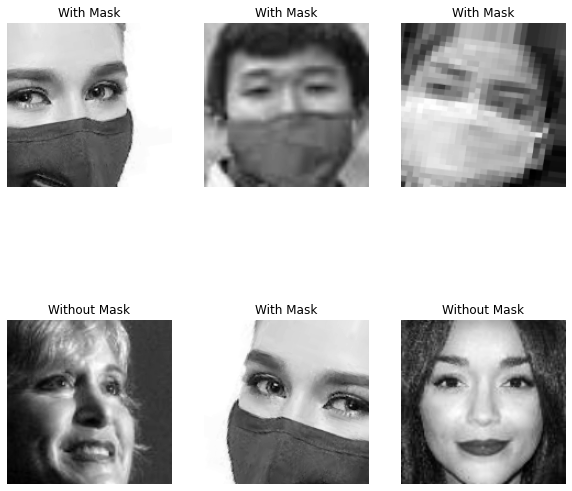

In [9]:
## Looking at the training samples

fig, ax = plt.subplots(2, 3, figsize=(10, 10))

for row in range(2):
    for col in range(3):
        image_index = row*100+col
        
        ax[row, col].axis("off")
        ax[row,col].imshow(data[image_index][0], cmap = "gray")
    
        if data[image_index][1] == 0:
            ax[row, col].set_title("Without Mask")
        else:
            ax[row, col].set_title("With Mask")
            
plt.show()

In [10]:
X = []
y = []

## Seperating X and y
for image in data:
    X.append(image[0])
    y.append(image[1])
    
## Converting X and y to numpy array as Tensorflow accepts only numpy arrays
X = np.array(X)
y = np.array(y)

### Normalizing the data
X = X/255

### Train Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [12]:
model = tf.keras.models.load_model('classification_09831')

2022-04-10 22:51:41.600396: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO: Detected tensorflow backend for <class 'keras.engine.sequential.Sequential'>.
INFO: Using backend Backend.TENSORFLOW.
INFO: If this seems incorrect, you can force the correct backend by passing the `backend` parameter directly into your get_model_wrapper call.


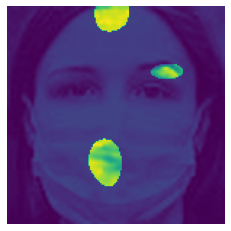

In [41]:
model_wrapped = get_model_wrapper(model)

# Create the attribution measure.
ig_computer = IntegratedGradients(model_wrapped, resolution=10)
# Calculate the input attributions.
with PIL.Image.open('46.png').convert() as img:
    img = PIL.ImageOps.grayscale(img)
    x_pp = np.array(img.resize((150,150), PIL.Image.ANTIALIAS))[np.newaxis]
    x_pp = x_pp[..., np.newaxis]
    input_attributions = ig_computer.attributions(x_pp)
    
# Visualize the attributions as a mask on the original image.
visualizer = MaskVisualizer(blur=10, threshold=0.95)

visualization = visualizer(input_attributions, x_pp)


In [49]:
plt.imsave('trulens.png', visualization, dpi=300)

<Figure size 2592x864 with 0 Axes>